In [99]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [100]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,1,0,0,0,0,98166,47.4697,-122.351
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [101]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'condition', 'water_1.0',
       'base_1.0', 'reno_1.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E',
       'zip_F', 'zip_G', 'zip_H', 'zip_I', 'zipcode', 'lat', 'long'],
      dtype='object')

# MODEL: USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [102]:
#including all log-transformed features without neighborhood information
preprocessed = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 'condition', 
                      'water_1.0', 'base_1.0', 'reno_1.0', 
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

With the linear regression, you would interpret log transformed variables as a percentage change. Here’s a quick breakdown: (http://data-slinky.com/2016/09/06/log_trans.html)

* If your response variable, y, is log-transformed and assuming you have one predictor, a unit increase in the predictor x is associated with the x’s coefficient, call it b1, (b1*100) percentage increase in y.
* If your predictor is log-transformed(e.g., log(x)), then one unit increase of x means a (b1/100) percent increase in y.
* If both the response and the predictor is log-transformed then a one percent increase in x means a b1 percent increase in y.

In [103]:
preprocessed.shape

(21420, 22)

In [104]:
X = preprocessed.drop(['price'], axis=1)
y = preprocessed['price']

## Perform Stepwise Selection

In [105]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [106]:
#apply function
result = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result)

Add  sqft_above                     with p-value 0.0
Add  age                            with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 1.95187e-231
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  condition                      with p-value 2.14375e-24
Add  zip_F                          with p-value 5.07427e-17
Add  reno_1.0                       with p-value 7.82094e-14
Add  zip_E                          with p-value 1.59623e-09
Add  zip_I                          with p-value 3.54966e-10
Add  floors                         with p-value 8.16227e-08
Resulting Features

In [107]:
#check out how many features satisfy p < 0.05
len(result)

17

## Build Model in Statsmodels

In [108]:
#build initial model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model = sm.OLS(y, X_intercept).fit() 

#get summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2537.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        03:31:57   Log-Likelihood:            -2.9307e+05
No. Observations:               21420   AIC:                         5.862e+05
Df Residuals:                   21402   BIC:                         5.863e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.734e+05   1.23e+04    -38.574      0.000   -4.97e+05   -4.49e+05
sqft_above      238.2810      3.607     66.067      0.000     231.212     245.350
age            1795.5236     76.520     23.465      0.000    1645.538    1945.509
zip_A          2.699e+05   5156.222     52.352      0.000     2.6e+05     2.8e+05
bathrooms      7.877e+04   3394.522     23.205      0.000    7.21e+04    8.54e+04
base_1.0       1.208e+05   3897.556     30.996      0.000    1.13e+05    1.28e+05
water_1.0      8.517e+05   1.79e+04     47.612      0.000    8.17e+05    8.87e+05
zip_C           2.89e+05   5820.363     49.647      0.000    2.78e+05       3e+05
sqft_living15    95.2318      3.426     27.798      0.000      88.517     101.947
zip_B          1.747e+05   5557.677     31.438      0.000    1.64e+05    1.86e+05
bedrooms      -4.079e+04   2036.446    -20.029      0.000   -4.48e+04   -3.68e+04
zip_G          1.268e+05   6403.872     19.804      0.000    1.14e+05    1.39e+05
condition      2.962e+04   2494.956     11.872      0.000    2.47e+04    3.45e+04
zip_F         -3.018e+04   6437.936     -4.688      0.000   -4.28e+04   -1.76e+04
reno_1.0       6.609e+04   8383.722      7.883      0.000    4.97e+04    8.25e+04
zip_E           5.14e+04   7036.639      7.305      0.000    3.76e+04    6.52e+04
zip_I          5.994e+04   9512.033      6.302      0.000    4.13e+04    7.86e+04
floors         -2.08e+04   3875.811     -5.365      0.000   -2.84e+04   -1.32e+04
==============================================================================
Omnibus:                    17982.451   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1611755.450
Skew:                           3.532   Prob(JB):                         0.00
Kurtosis:                      44.905   Cond. No.                     3.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* We have a JB value = ~978, which is very high and not in favor of normality. 
* p-value of 0 which rejects the null hypothesis for normality. 
* Additionally, the kurtosis is ~4, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. 
* The skewness value of 0.17 shows that underlying data is symmetrical. 

**Recheck for multicollinearity**

In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed[result]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(result, vif))

[('sqft_above', 23.09921177159362),
 ('age', 7.464595733279085),
 ('zip_A', 4.235821564287904),
 ('bathrooms', 27.668109656187234),
 ('base_1.0', 2.8322440719212114),
 ('water_1.0', 1.0386918416636421),
 ('zip_C', 1.9489506591698975),
 ('sqft_living15', 22.822924527843938),
 ('zip_B', 1.9051944248337302),
 ('bedrooms', 22.34552908699813),
 ('zip_G', 1.6436828466138298),
 ('condition', 22.407943921005135),
 ('zip_F', 1.481440074935204),
 ('reno_1.0', 1.158747939143213),
 ('zip_E', 1.440848892661724),
 ('zip_I', 1.1888823460120768),
 ('floors', 15.036559412721239)]

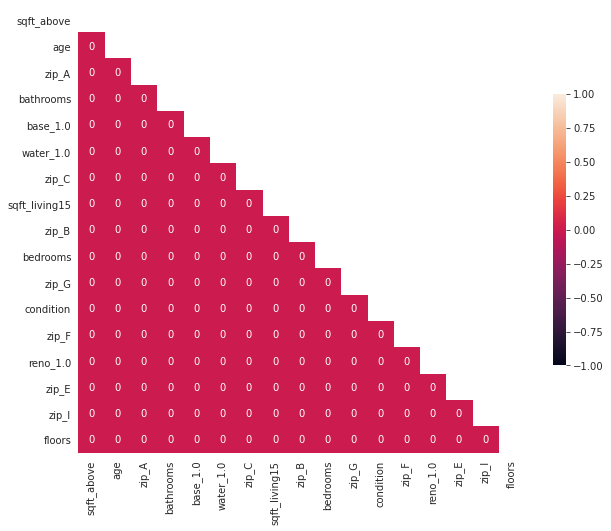

In [110]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/model_multicollinarity_check')

**Recheck for normality**

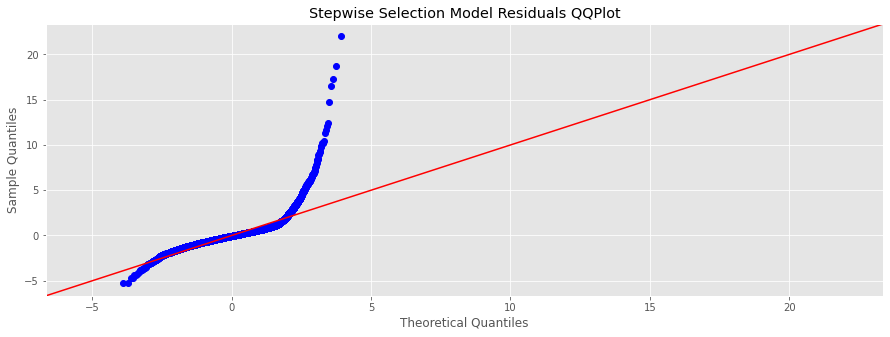

<Figure size 432x288 with 0 Axes>

In [111]:
#recheck for normality
fig = sm.graphics.qqplot(model.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Stepwise Selection Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_residuals_qqplot')

**Recheck for homoscedasticity**

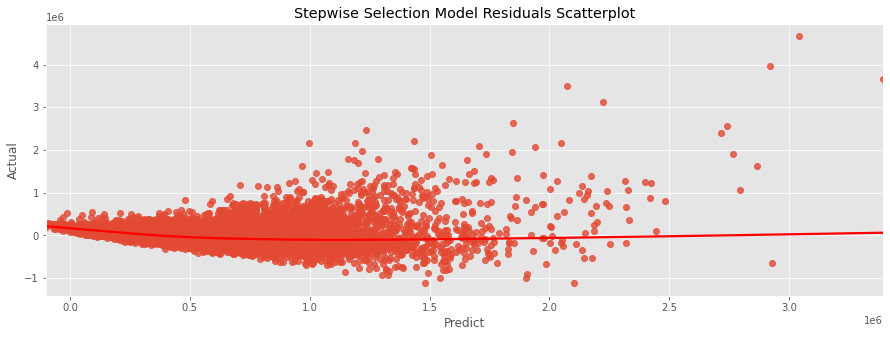

<Figure size 432x288 with 0 Axes>

In [112]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model.predict(), 
            y = model.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Stepwise Selection Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_homoscedasticity_regplot')

**Recheck for overfitting: K-Fold Cross Validation**

In [113]:
#cross-validation to check for overfitting (learn.co)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 50, scoring = mse)
cv_result

array([9.01603548e+10, 3.31163186e+10, 2.87709877e+10, 1.05035129e+11,
       4.44786579e+10, 1.91281485e+10, 2.18087352e+10, 4.17530245e+10,
       2.97230927e+10, 3.09668873e+10, 3.91405745e+10, 4.33608135e+10,
       4.83408969e+10, 3.75043145e+10, 2.59138219e+10, 7.94908211e+10,
       4.83136206e+10, 5.13982049e+10, 4.44267113e+10, 5.26181056e+10,
       2.86964361e+10, 6.07592833e+10, 4.90242535e+10, 5.05151670e+10,
       2.34691864e+10, 6.45121159e+10, 3.52169288e+10, 5.47918016e+10,
       3.12725679e+10, 3.36823305e+10, 4.52633007e+10, 4.71212069e+10,
       2.39731379e+10, 3.23532103e+10, 5.83641682e+10, 7.32062214e+10,
       4.83508229e+10, 3.46030575e+10, 5.14661952e+10, 2.78533696e+10,
       4.82627458e+10, 2.70111473e+10, 5.57544262e+10, 4.55034383e+10,
       9.35965643e+10, 5.89989524e+10, 4.39739099e+10, 2.98987722e+10,
       4.28759726e+10, 3.45794419e+10])

In [114]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

45407987064.59885

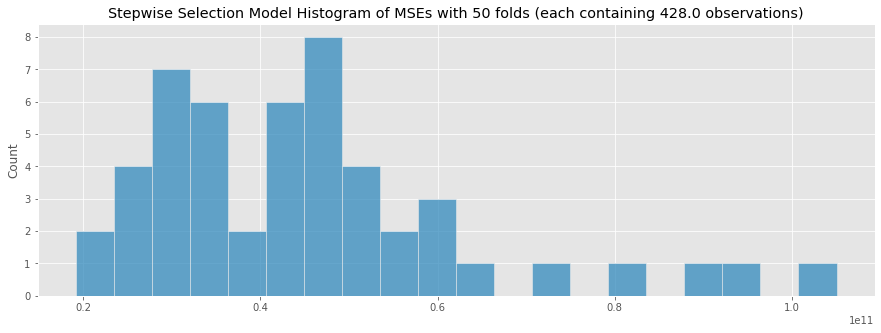

In [115]:
#visualize the cv_result

folds = 50
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Stepwise Selection Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed) / folds, 0)));
plt.savefig('./Data & Figures/model_cv_result_histplot')

The above histogram suggests that even with 50 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

## Validate Model

In [116]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [117]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [118]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [119]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

42772026289.30154
53402295306.34543


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

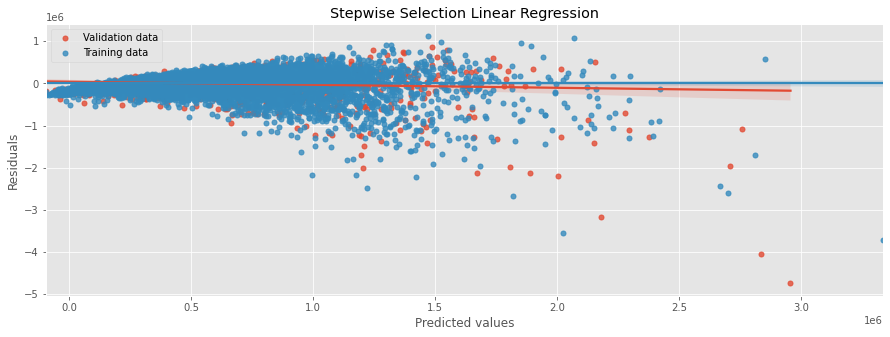

<Figure size 432x288 with 0 Axes>

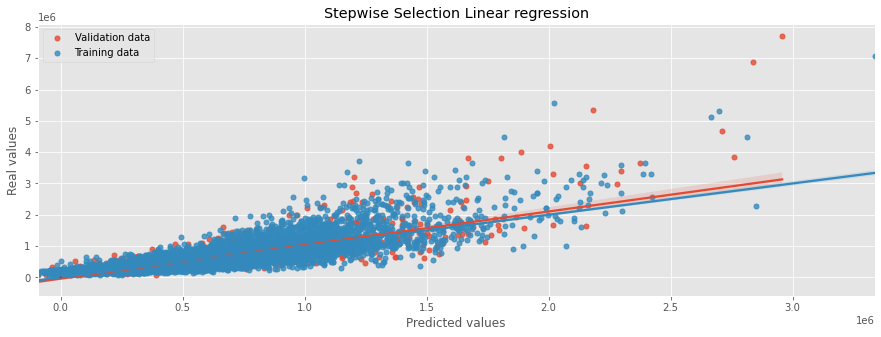

<Figure size 432x288 with 0 Axes>

In [120]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")


plt.title("Stepwise Selection Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_residuals_scatterplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")

plt.title("Stepwise Selection Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()
plt.savefig('./Data & Figures/model_predictions_scatterplot')

In [121]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 66%'

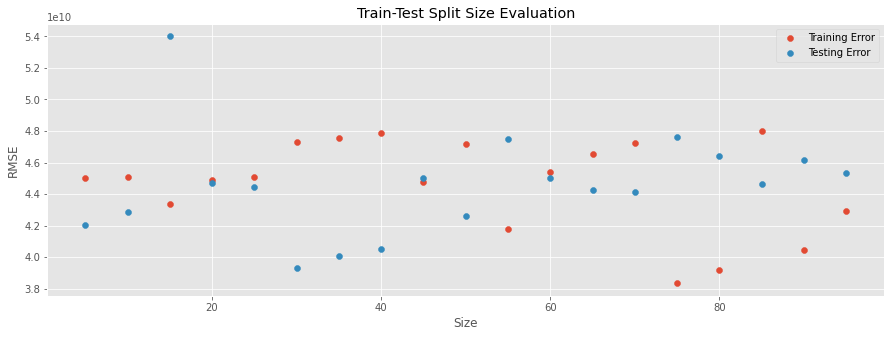

In [122]:
#evaluating the effect of train-test split size (learn.co)
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.title('Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('./Data & Figures/model_traintestsplit_scatterplot')

### Bias-Variance Tradeoff

In [123]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [124]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [125]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [126]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -774906.1956328461 
Train variance: 24988661521.6389
